In [88]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
%matplotlib inline

In [89]:
env = gym.make('CartPole-v1')
env.seed(1); torch.manual_seed(1);

task1
CartPoleEnv - Version 0.2.0, Noise case: 1
task1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [90]:
#Hyperparameters
learning_rate = 0.01
gamma = 0.99

In [91]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128,32, bias=False)
        self.l3 = nn.Linear(32,self.action_space, bias=False)
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_history = (torch.tensor(0))        
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []

    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
#             nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l2,
#             nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l3,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [92]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

In [93]:
def select_action(state):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy(Variable(state))
    c = Categorical(state)
    action = c.sample()
    # Add log probability of our chosen action to our history
    if policy.policy_history.dim() != 0:
        policy.policy_history = torch.cat((policy.policy_history, c.log_prob(action).view(1)),0)
    else:
        policy.policy_history = (c.log_prob(action)).view(1)
    return action

In [94]:
def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, Variable(rewards)).mul(-1), -1))
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss)
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = Variable(torch.Tensor())
    policy.reward_episode= []

In [100]:
def main(episodes):
    running_reward = 10
    count = 0 
    max_ = 20
    for episode in range(episodes):
        state = env.reset() # Reset environment and record the starting state
        done = False       
    
        for time in range(1000):
            action = select_action(state)
            # Step through environment using chosen action
            state, reward, done, _ = env.step(int(action.data))

            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        
        if(time == 499) :
            count += 1
            if(count > max_) :
                print("max",max_)
                max_ = count
                torch.save(policy,"pg_task1_.pkl")
                if max_ == 100 :
                    break
        else :
#             count = 0 
            pass
            
        # Used to determine when the environment is solved.
        running_reward = (running_reward * 0.99) + (time * 0.01)
        
        update_policy()

        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))        

In [101]:
episodes = 10000
main(episodes)

Episode 0	Last length:   499	Average length: 14.89
max 20


/Users/uj007/anaconda3/envs/mlproject/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


max 21
max 22
max 23
max 24
max 25
max 26
max 27
max 28
max 29
max 30
max 31
max 32
max 33
max 34
max 35
max 36
max 37
max 38
max 39
max 40
max 41
max 42
max 43
max 44
max 45
max 46
max 47
max 48
max 49
Episode 50	Last length:   499	Average length: 204.95
max 50
max 51
max 52
max 53
max 54
max 55
max 56
max 57
max 58
max 59
max 60
max 61
max 62
max 63
max 64
max 65
max 66
max 67
max 68
max 69
max 70
max 71
max 72
max 73
max 74
max 75
max 76
max 77
max 78
max 79
max 80
max 81
max 82
max 83
max 84
max 85
max 86
max 87
max 88
max 89
max 90
max 91
max 92
max 93
max 94
max 95
Episode 100	Last length:   499	Average length: 316.95
max 96
max 97
max 98
max 99


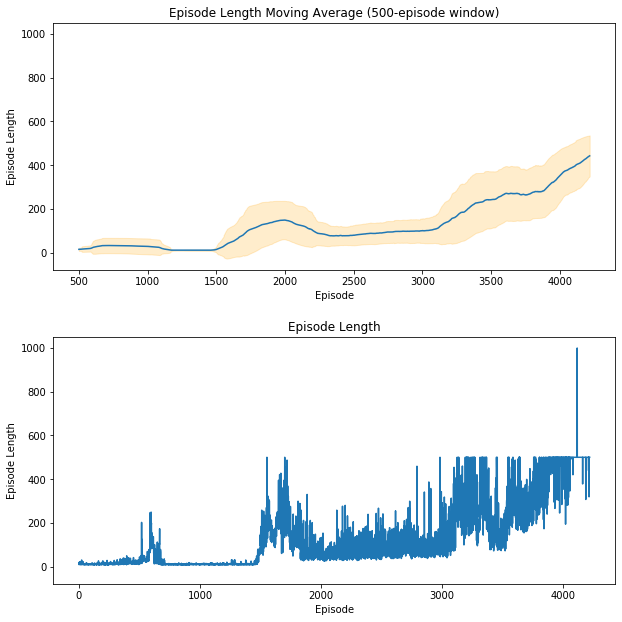

In [102]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')


In [103]:
test_episodes = 100
test_max_steps = 500
avg = 0 
policy = torch.load("pg_task1_.pkl")
policy.eval()
for episode in range(1, test_episodes):
    t = 0
    rew = 0 
    env.reset()
    while t < test_max_steps: 
        
        if(t == 0) :
            action = 0 
        else :
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = policy(Variable(state))
            action = state.max(0)[1]
            
        state, reward, done , _ = env.step(int(action))
        rew += reward
        t += 1
        if(done) :
            break 
    avg += rew
print(avg/test_episodes)
env.close()

480.49
